## Extract one OC with the DBSCAN parameters

In [29]:
using PyCall
using Statistics , StatsBase
using  DataFrames, Printf , CSV , Query

import PyPlot
sns= pyimport("seaborn")

## directory
rootdir = ENV["GAIA_ROOT"]
wdir    = "$rootdir/products"
votdir  = "$rootdir/products/votable.2020"
plotdir = "$rootdir/products/test"
sclist  = "$rootdir/e2e_products/sc-list-2020.csv"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

apy= pyimport("astropy")
coord= pyimport("astropy.coordinates")

cd(wdir)

In [30]:
function _get_OC(df , dfcart, labels , labelmax)
    ra= df.raw[1, labels[labelmax]]
    dec= df.raw[2,labels[labelmax]]
    l= df.data[1, labels[labelmax]]
    b= df.data[2,labels[labelmax]]
    d= df.data[3,labels[labelmax]]
    pmra= df.raw[6, labels[labelmax]]
    pmdec= df.raw[7, labels[labelmax]]
    X= dfcart.data[1, labels[labelmax]]
    Y= dfcart.data[2, labels[labelmax]]
    Z= dfcart.data[3, labels[labelmax]]
    vl= df.data[4,labels[labelmax]]
    vb= df.data[5,labels[labelmax]]
    vrad= df.raw[13,labels[labelmax]]
    gbar= df.raw[10,labels[labelmax]]
    rp= df.raw[11,labels[labelmax]]
    bp= df.raw[12,labels[labelmax]]
    ag= df.raw[14,labels[labelmax]]

    oc= DataFrame(ra=ra,dec=dec,l=l,b=b, distance=d,pmra=pmra, pmdec=pmdec, X=X,Y=Y,Z=Z,vl=vl,vb=vb,vrad=vrad,gbar=gbar,rp=rp,bp=bp, ag=ag)

    return(oc)
end

function _getdata(voname, wghtblck)
    data       = read_votable(voname)
    df         = filter_data(data)
    dfcart     = add_cartesian(df)
    blck       = [[1,2,3],[4,5], [6,7,8]]
    norm       = "identity"

    dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false)
    return(df, dfcart , dfcartnorm)
end

_getdata (generic function with 1 method)

In [31]:
## return the "best cluster"

function _find_cluster_label(labels, df::GaiaClustering.Df, dfcart::GaiaClustering.Df ,
    aperture2d = 1.5, maxaperture2d = 15, aperturev = 3.0, maxaperturev = 20, nboot = 30)
    
    ### metrics of the clusters
    q2d = metric2(dfcart, labels, "spatial2d" , aperture2d, maxaperture2d, nboot)
    q3d = metric2(dfcart, labels, "spatial3d" , aperture2d, maxaperture2d, nboot)     #### Added
    qv  = metric2(dfcart, labels, "velocity" , aperturev, maxaperturev, nboot)
    qp, qa = metric2(dfcart, labels, "HRD" )

    nlab = []
    for ilab in labels
        push!(nlab,length(ilab))
    end
    
    #### metric for the number of stars in the cluster
    qn = []
    for nl in nlab
        push!(qn,log10(nl))
    end
    
    qc= []
    for i in 1:length(nlab)
        k1 = q2d[i][1]
        k1bis = q3d[i][1]
        k2 = qv[i][1]
        k3 = qa[i][1]
        k4 = qn[i]
        ############### Composite metric ###
        qq = (2k1 + k1bis + 3k2 + k3 + k4) / 8.0
        # qq = (3k1 + k1bis + 3k2 + k4) / 8.0
        ###############
        push!(qc,qq)
    end
    
    println(qc)
    bestlabel= findmax(qc)[2]
    println("best label $bestlabel")
    
    return(bestlabel, nlab[bestlabel])
end

_find_cluster_label (generic function with 6 methods)

In [32]:
## function to compute distance of detected cluster to "standard" position
##

function _get_pos(votname, sclist)
    u= apy.units
    scdata= CSV.read(sclist,delim="|")
    
    nf= findlast("deg", votname)[1]-5  ## deg-5 chars
    name= votname[1:nf]
    println(name)
    
    q = @from i in scdata begin
     @where i.name == name
     @select {ra=i.ra, dec= i.dec}
     @collect DataFrame
    end
    
    println(q)
    ra= q.ra[1] ; dec= q.dec[1]
    co= "$ra $dec"
    c= coord.SkyCoord(co, unit=(u.hourangle, u.deg))
    
    α= c.ra
    δ= c.dec
    
    return(α[1],δ[1])
end

function _get_angle2pos(oc,α_c, α_c)
    α= median(oc.ra)
    δ= median(oc.dec)
        
    angdist= angle4sphere(α, δ ,α_c, α_c )
    return(angdist)
end

ErrorException: syntax: function argument names not unique

In [33]:
votname= "FSR 0224-2.0deg.vot"


w3d=  4.4
wvel=   8.3
whrd=  2.9

wght= [w3d, wvel, whrd]
df , dfcart , dfcartnorm = _getdata(votdir*"/"*votname, wght)

eps     =  1.865
min_cl  = 19
min_nei = 8


labels = clusters(dfcartnorm.data ,eps  , 20, min_nei, min_cl)
labelbest, nstars= _find_cluster_label(labels, df, dfcart)
# labelmax , nmax = find_cluster_label(labels)

α_c , δ_c = _get_pos(votname, sclist)

oc= [] ; angle= []
for i in 1:length(labels)
    oci= _get_OC(df , dfcart, labels , i)
    angle_c= _get_angle2pos(oci, α_c, δ_c)
    push!(oc,oci)
    push!(angle,angle_c)
end

## Votable /home/stephane/Science/GAIA/products/votable.2020/FSR 0224-2.0deg.vot read
## Filtering done ...
## Stars selected: 68309
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag,1mag] equivalent to [0.2959157811470433, 0.2959157811470433, 0.2959157811470433, 0.5582047689819226, 0.5582047689819226, 0.19503540121055127, 0.19503540121055127, 0.19503540121055127]
##
Any[2.7281783582059718, 1.2293042375034373, 1.3885758920192952]
best label 1
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 2. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 3. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 4. Igno

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 77. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 78. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 79. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 80. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 81. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 82. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 83. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end 

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 154. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 155. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 156. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 157. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 158. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 159. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 160. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't rea

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 231. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 232. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 233. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 234. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 235. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 236. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 237. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't rea

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 308. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 309. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 310. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 311. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 312. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 313. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 314. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't rea

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 385. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 386. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 387. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 388. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 389. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 390. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 391. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't rea

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 462. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 463. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 464. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 465. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 466. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 467. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 468. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't rea

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 539. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 540. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 541. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 542. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 543. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 544. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 545. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't rea

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 616. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 617. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 618. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 619. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 620. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 621. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 622. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't rea

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 693. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 694. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 695. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 696. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 697. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 698. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 699. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't rea

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 770. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 771. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 772. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 773. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 774. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 775. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 776. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't rea

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 847. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 848. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 849. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 850. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 851. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 852. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 853. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't rea

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 924. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 925. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 926. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 927. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 928. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 929. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 930. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't rea

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1001. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1002. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1003. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1004. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1005. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1006. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1007. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but did

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1077. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1078. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1079. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1080. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1081. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1082. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1083. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but did

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1153. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1154. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1155. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1156. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1157. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1158. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1159. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but did

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1229. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1230. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1231. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1232. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1233. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1234. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1235. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but did

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1305. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1306. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1307. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1308. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1309. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1310. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1311. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but did

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1381. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1382. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1383. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1384. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1385. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1386. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1387. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but did

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1457. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1458. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1459. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1460. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1461. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1462. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1463. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but did

thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1533. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1534. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1535. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1536. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1537. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1538. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but didn't reach end of line on data row: 1539. Ignoring any extra columns on this row
thread = 1 warning: parsed expected 10 columns, but did

In [34]:
## plot_cluster

function _plot_oc(df, angdist= 0)
    PyPlot.plt.figure(figsize=(13.0,12.0))

    PyPlot.plt.subplot(3, 3, 1 , xlim = [-20,20] , ylim = [-20,20])
    PyPlot.plt.scatter(df.Y .- mean(df.Y), df.Z .- mean(df.Z) , s = 1.0 )
    PyPlot.plt.xlabel("Y (pc)")
    PyPlot.plt.ylabel("Z (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 2 , ylim = [-20,20])
    PyPlot.plt.scatter(df.X, df.Z .- mean(df.Z)  , s = 1.0 )
    PyPlot.plt.xlabel("X (pc)")
    PyPlot.plt.ylabel("Z (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 4 , xlim = [-20,20])
    PyPlot.plt.scatter(df.Y .- mean(df.Y) , df.X, s = 1.0 )
    PyPlot.plt.xlabel("Y (pc)")
    PyPlot.plt.ylabel("X (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 3 )
    PyPlot.plt.scatter(df.X, df.vrad , s = 1.0 )
    PyPlot.plt.xlabel("X(pc)")
    PyPlot.plt.ylabel("Vrad (km/s)")
    PyPlot.plt.grid(true)    
        
    PyPlot.plt.subplot(3, 3, 5)
    PyPlot.plt.axis("off")
    ## text to display
    text =[]
    txt = @sprintf("N stars: %3d",length(df.X)) ; push!(text,txt)
    txt = @sprintf("Distance: %3.1f (pc) +/- %3.1f",median(df.distance), std(df.distance)) ; push!(text,txt)
    txt = @sprintf("Angular distance: %3.2f (degree)", angdist) ; push!(text,txt)
    txt = @sprintf("l: %3.3f (degree)",median(df.l)) ; push!(text,txt)
    txt = @sprintf("b: %3.3f (degree)",median(df.b)) ; push!(text,txt)  
    txt = @sprintf("Vl: %3.2f (km/s)",median(df.vl)) ; push!(text,txt) 
    txt = @sprintf("Vb: %3.2f (km/s)",median(df.vb)) ; push!(text,txt)
    txt = @sprintf("Vr: %3.2f (km/s, no masking)",median(df.vrad)) ; push!(text,txt)
    txt = @sprintf("X disp.: %3.2f (pc)", std(df.X)) ; push!(text,txt)
    txt = @sprintf("Y disp.: %3.2f (pc)", std(df.Y)) ; push!(text,txt)  
    txt = @sprintf("Z disp.: %3.2f (pc)", std(df.Z)) ; push!(text,txt)
    txt = @sprintf("Vl disp.: %3.2f (km/s) ", std(df.vl)) ; push!(text,txt)
    txt = @sprintf("Vb disp.: %3.2f (km/s)", std(df.vb)) ; push!(text,txt)
    txt = @sprintf("Vr disp.: %3.2f (km/s)", std(df.vrad)) ; push!(text,txt)
    show_text(-0.01,0.0, text , 1.0)
    
    PyPlot.plt.subplot(3, 3, 7 )
    PyPlot.plt.axis("on")    
    PyPlot.plt.scatter(df.gbar-df.rp, -df.gbar , s = 1.0 )
    PyPlot.plt.xlabel("G-Rp")
    PyPlot.plt.ylabel("G")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 8 )
    PyPlot.plt.scatter(df.vl, df.vb , s = 1.0 )
    PyPlot.plt.xlabel("Vl (km/s)")
    PyPlot.plt.ylabel("Vb (km/s)")
    PyPlot.plt.grid(true)
end

_plot_oc (generic function with 2 methods)

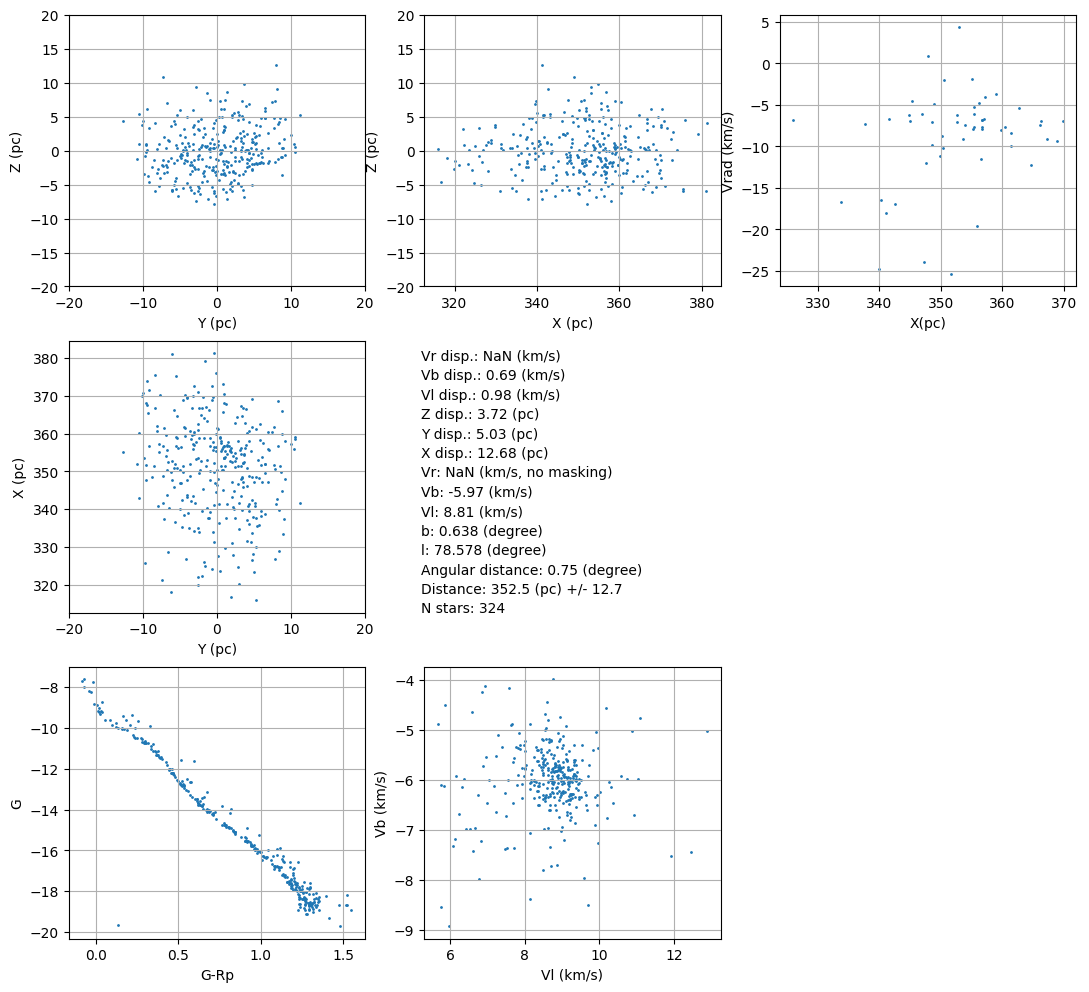

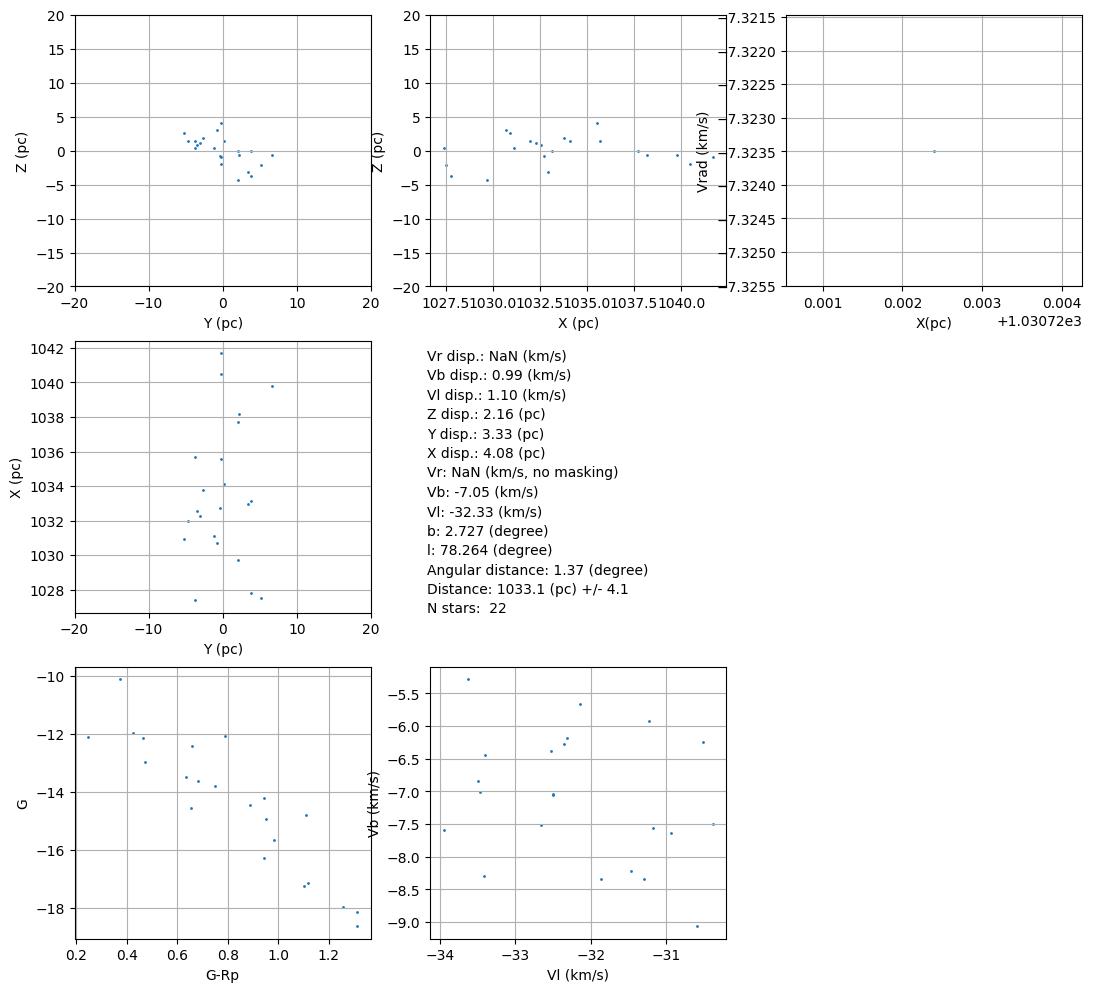

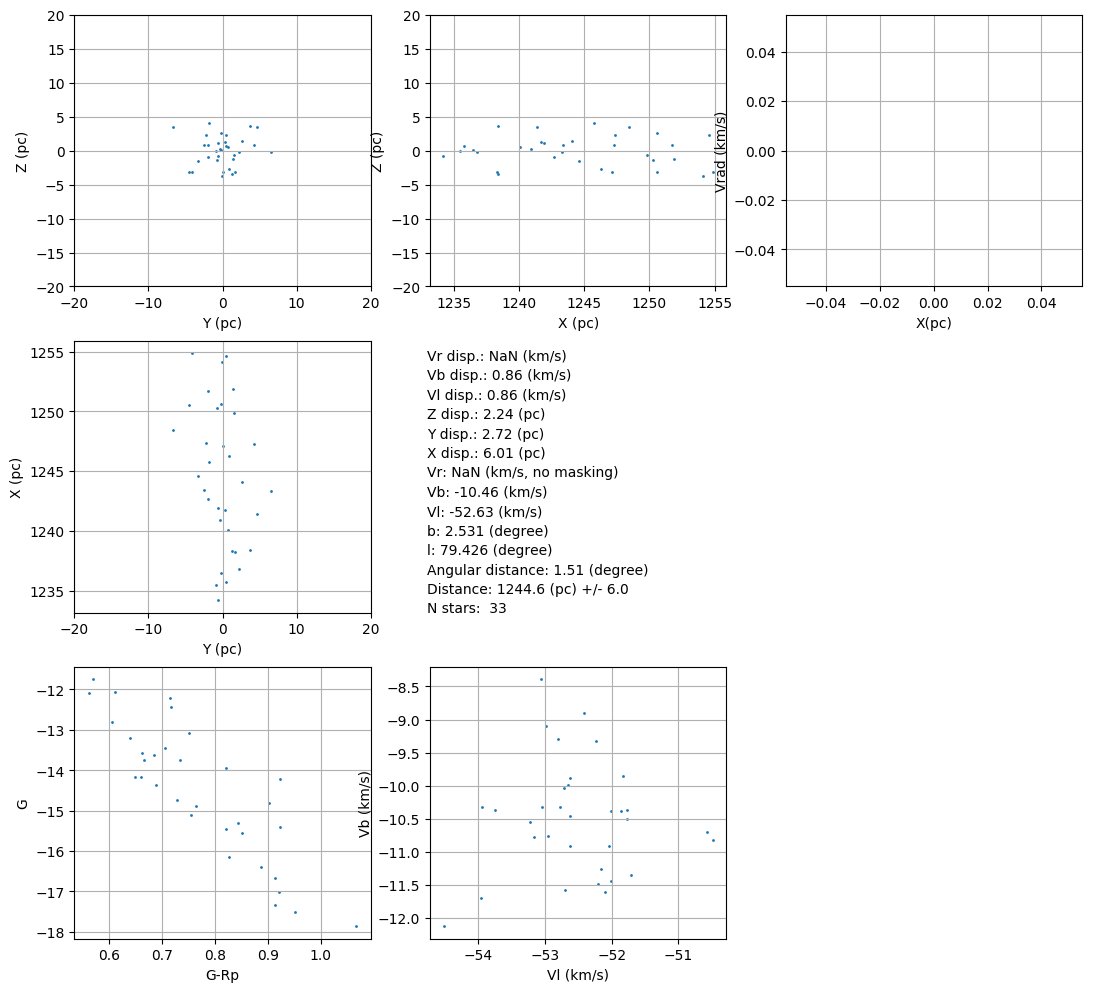

In [37]:
for i in 1:length(labels)
    _plot_oc(oc[i], angle[i])
    PyPlot.savefig(plotdir*"/test_label_$i.png")
end